# Import libraries


In [1]:
#import libraries

# SUPPRESS WARININGs!!
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

SEED = 42

from google.colab import drive
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, auc,  roc_curve, classification_report, precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from collections import Counter
import math
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import gc
import cv2

import time
import glob

from tqdm import tqdm
import matplotlib.pyplot as plt


#drive.mount("/content/drive")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists('/kaggle/working'):
    # Siamo su Kaggle
    model_dir = "/kaggle/working"
    PATH = "/kaggle/input/test-ecg-pw02-1/drive-download-20251124T104021Z-1-001/"
else:
    # Siamo su Colab o locale
    model_dir = "./"
    PATH = "/content/drive/MyDrive/PW02-Neuroengineering/"
    

# HYPERPARAMETERS

In [2]:
# HERE WE SET ALL THE PARAMETERS THAT CAN BE MODIFIED 
# some tuned w optuna 


# fixed columns 
TARGET_COL = 'sport_ability'
ID_COL = 'ECG_patient_id'


# columns on tab dataset that we want to scale (add height, weight etc if dont dropped) 
COLS_TO_SCALE = ['age_at_exam']  


# k fold split
N_SPLITS = 5 


#DATA AUGMENTATION PARAMETERS
WINDOW_SIZE = 2500
STRIDE_TRAIN = 500  
STRIDE_VAL = 2000   

BATCH_SIZE = 32                             #tuned

JITTER_STRENGTH = 0.19204817214116615        # tuned

CHANNEL_MASK = 0.40278718758336346         # tuned


# MODEL PARAMETERS
LEARNING_RATE = 0.0006281996940933472        # tuned
EPOCHS = 200
PATIENCE = 25
VERBOSE = 10

PCT_START = 0.4580774462774424              # tuned

BASE_CHANNELS = 32                          # tuned

# REGULARIZATION
DROPOUT_RATE = 0.23118012099967702         # tuned
L1_LAMBDA = 0
L2_LAMBDA = 0.0021296084365636635           # tuned
LABEL_SMOOTHING = 0.15607306361745482       # tuned



# FUNCTIONS & CLASSES

In [3]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):      #  remove noise (50hz)
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [4]:
# func to normalize signals z-score
def normalize_instance_wise(signals):

    mean = np.mean(signals, axis=1, keepdims=True)
    std = np.std(signals, axis=1, keepdims=True)

    epsilon = 1e-8

    return (signals - mean) / (std + epsilon)

In [5]:
# function to build signals sequences (w overlap)
def build_sequences(signals, tabular, labels, window=2500, stride=1250):

    X_sig_seq = []
    X_tab_seq = []
    y_seq = []
    id_seq = []
    patient_ids = tabular['ECG_patient_id'].values

    num_patients = signals.shape[0]
    signal_len = signals.shape[1]

    for i in range(num_patients):

        curr_sig = signals[i]
        curr_tab = tabular.iloc[i].values
        curr_label = labels.iloc[i] if hasattr(labels, 'iloc') else labels[i]
        curr_id = patient_ids[i]

        idx = 0
        while idx + window <= signal_len:
            segment = curr_sig[idx : idx + window, :]

            X_sig_seq.append(segment)
            X_tab_seq.append(curr_tab)
            y_seq.append(curr_label)
            id_seq.append(curr_id)

            idx += stride

    return np.array(X_sig_seq), np.array(X_tab_seq), np.array(y_seq), np.array(id_seq)

In [6]:
# init dataset, w jitter(randomness) + mask
class ECGThreeBranchDataset(Dataset):
    def __init__(self, signals, tabular, labels=None, is_train=False, JITTER_STRENGTH=0, CHANNEL_MASK=0):
        """
        signals: (N, 2500, 12) -> splitted in (N, 6, 2500) and (N, 6, 2500)  --> to get 6 leads/6 leads
        """
        self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        self.tabular = torch.tensor(tabular, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

        self.is_train = is_train
        self.jitter_strength = JITTER_STRENGTH
        self.channel_mask_prob = CHANNEL_MASK

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        full_sig = self.signals[idx].clone()

        if self.is_train:

            shift = torch.randint(low=-250, high=250, size=(1,)).item()   #time shifting
            full_sig = torch.roll(full_sig, shifts=shift, dims=1)

            if self.jitter_strength > 0:          # jitter -> put JITTER_STRENGHT = 0 to pass w/
                noise = torch.randn_like(full_sig) * self.jitter_strength
                full_sig = full_sig + noise

            # Channel masking   --> turn a signal to 0 to prevent model laziness
            if self.channel_mask_prob > 0 and torch.rand(1) < self.channel_mask_prob:
                mask_idx = torch.randint(0, 12, (1,)).item()
                full_sig[mask_idx, :] = 0 
                
        
        # we get 3 dataset --> model needs 3 branch
        # branch 1: Limb Leads (first 6: I, II, III, aVR, aVL, aVF)
        limb_sig = full_sig[:6, :]      # Shape: (6, 2500)

        # Branch 2: Precordial Leads (last  6: V1-V6)
        prec_sig = full_sig[6:, :]      # Shape: (6, 2500)

        # Branch 3: Tabular
        tab_data = self.tabular[idx]

        if self.labels is not None:
            return limb_sig, prec_sig, tab_data, self.labels[idx]
        else:
            return limb_sig, prec_sig, tab_data

In [7]:
def make_loader(ds, batch_size, shuffle, drop_last=False):

    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=2,
    )

In [ ]:
# squeeze and extract block, used in conv ResNet ---> introduce channel attention

'''
Squeeze-and-Excitation Networks
Jie Hu, Li Shen, Gang Sun 
CVPR 2018 (IEEE Conference on Computer Vision and Pattern Recognition)
https://arxiv.org/abs/1709.01507
'''

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

In [ ]:

'''
convolution source:
      Cardiologist-level arrhythmia detection and classification in ambulatory electrocardiograms using a deep neural network
      Hannun, A. Y., Rajpurkar, P., Ng, A. Y., et al.
      Nature Medicine (2019)
      Link: Nature Medicine Article | https://arxiv.org/abs/1707.01836

      Deep Residual Learning for Image Recognition
      Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun 
      CVPR 2016
      https://arxiv.org/abs/1512.03385
'''

class MicroResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1):
        super(MicroResNetBlock, self).__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = SEBlock(out_channels, reduction=4)
        self.shortcut = nn.Sequential()
        if stride > 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)
        out += residual
        out = self.relu(out)
        return out

In [10]:
# MODEL --> 3 branches, 3 diff input

class ThreeBranchSimpleCNN(nn.Module):
    def __init__(self, n_tabular_features, n_classes, dropout=0.5, base_channels=32): 
        super(ThreeBranchSimpleCNN, self).__init__()

        c1 = base_channels       # base channel lenght
        c2 = base_channels * 2   
        c3 = base_channels * 4  

        def make_resnet_branch():    # func to make ResNet conv of all 3 datasets
            return nn.Sequential(
                MicroResNetBlock(in_channels=6, out_channels=c1, kernel_size=15, stride=1), 
                nn.MaxPool1d(2),
                MicroResNetBlock(in_channels=c1, out_channels=c2, kernel_size=7, stride=2),
                nn.MaxPool1d(2),
                MicroResNetBlock(in_channels=c2, out_channels=c3, kernel_size=5, stride=2),
                nn.AdaptiveAvgPool1d(1) 
            )

        self.branch_limb = make_resnet_branch()
        self.branch_prec = make_resnet_branch()

        self.branch_tab = nn.Sequential(
            nn.Linear(n_tabular_features, c2),
            nn.BatchNorm1d(c2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        fusion_dim = c3 + c3 + c2
        
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, c3 * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(c3 * 2, n_classes)
        )

    def forward(self, limb, prec, tab):
        x_limb = self.branch_limb(limb).squeeze(-1)
        x_prec = self.branch_prec(prec).squeeze(-1)
        x_tab = self.branch_tab(tab)
        combined = torch.cat([x_limb, x_prec, x_tab], dim=1)
        return self.classifier(combined)

In [11]:
# train function
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    for limb_in, prec_in, tab_in, targets in train_loader:
        limb_in = limb_in.to(device)
        prec_in = prec_in.to(device)
        tab_in = tab_in.to(device)
        targets = targets.to(device).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
            logits = model(limb_in, prec_in, tab_in)
            loss = criterion(logits, targets)

            # we dont need L1, but here is the logic to make it work  -  L2 already managed by AdamW
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                loss += l1_lambda * l1_norm


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * targets.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')
    return epoch_loss, epoch_f1

In [12]:
# validate function
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'

    with torch.no_grad():
        for limb_in, prec_in, tab_in, targets in val_loader:
            limb_in = limb_in.to(device)
            prec_in = prec_in.to(device)
            tab_in = tab_in.to(device)
            targets = targets.to(device).long()

            with torch.amp.autocast(device_type=device_type, enabled=(device.type=='cuda')):
                logits = model(limb_in, prec_in, tab_in)
                loss = criterion(logits, targets)

            running_loss += loss.item() * targets.size(0)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')
    return epoch_loss, epoch_f1

In [13]:
# here we train and validate the model
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, verbose=1, experiment_name="best_model"):

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Start Training: {epochs} epochs on {device}... \n")
    start_time = time.time()

    for epoch in range(1, epochs + 1):

        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, scaler, device, l1_lambda, l2_lambda
        )

        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # print
        if verbose > 0 and (epoch % verbose == 0 or epoch == 1):
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} F1: {train_f1:.4f} | "
                  f"Val Loss: {val_loss:.4f} F1: {val_f1:.4f} | "
                  f"LR: {current_lr:.6f}")

        # early stopping
        if patience > 0:
            current_metric = val_f1 if evaluation_metric == "val_f1" else val_loss

            if mode == 'max':
                is_improvement = current_metric > best_metric
            else:
                is_improvement = current_metric < best_metric

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), f"{model_dir}/{experiment_name}.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch} epochs.")
                    break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/60:.2f} minutes.")

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(f"{model_dir}/{experiment_name}.pt", map_location=device))
        print(f"Recovered best model: Epoch {best_epoch} with {evaluation_metric}: {best_metric:.4f}")

    return model, training_history

In [14]:
#  function to support k fold

# get and scale dataset, only on train obv
def get_fold_scaler(X_tab_train, cols_to_scale=['age_at_exam']):
    scaler = MinMaxScaler()
    scaler.fit(X_tab_train[cols_to_scale])
    return scaler

#scale dataset
def process_tabular_data(X_tab, scaler, cols_to_scale=['age_at_exam']):
    X_tab_scaled = X_tab.copy()
    X_tab_scaled.loc[:, cols_to_scale] = scaler.transform(X_tab[cols_to_scale])
    return X_tab_scaled

#retunr a empty model + optimizer(w AdamW)
def get_model_optimizer(device, n_tab_feats, n_classes, lr=1e-4, weight_decay=5e-2, dropout = 0.5, base_channels = 8):
    model = ThreeBranchSimpleCNN(
        n_tabular_features=n_tab_feats,
        n_classes=n_classes,
        dropout=dropout,
        base_channels = base_channels
    ).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    return model, optimizer

# get answer probs, to validate w soft voting (average of probs)
def get_all_probs(model, loader, device):
    model.eval()
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for limb, prec, tab, targets in loader:
            limb, prec, tab = limb.to(device), prec.to(device), tab.to(device)
            
            logits = model(limb, prec, tab)
            
            probs = torch.softmax(logits, dim=1)[:, 1] 
            
            all_probs.append(probs.cpu().numpy())
            all_targets.append(targets.numpy())
            
    return np.concatenate(all_probs), np.concatenate(all_targets)

In [ ]:
''' 
ALL PLOTTING FUNCTION HERE
'''

def plot_single_metric(ax, histories, metric_key, title, ylabel, colors):
    for i, h in enumerate(histories):
        ax.plot(h[metric_key], color=colors[i], lw=2, alpha=0.8, label=f'Fold {i+1}')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize='small')


def plot_roc_curves(ax, roc_data, colors):
    n_folds = len(roc_data)
    ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='black', alpha=0.5)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, data in enumerate(roc_data):
        y_true = data['true']
        y_score = data['prob']
        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        
        # Plot curva del fold
        ax.plot(fpr, tpr, color=colors[i], lw=2, alpha=0.6, 
                label=f'Fold {i+1} (AUC = {roc_auc:.3f})')
        
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        
    mean_tpr /= n_folds
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    ax.plot(mean_fpr, mean_tpr, color='black', linestyle='-', lw=3, 
            label=f'Mean ROC (AUC = {mean_auc:.3f})')
            
    ax.set_title('ROC Curves (Patient Level)', fontsize=14)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right", fontsize='small')
    ax.grid(True, alpha=0.3)


def plot_kfold_results(histories, roc_data):

    n_folds = len(histories)
    colors = plt.cm.tab10(np.linspace(0, 1, n_folds))
    
    fig = plt.figure(figsize=(20, 18))
    gs = fig.add_gridspec(3, 2) 
    
    # --- LOSS ---
    ax_tl = fig.add_subplot(gs[0, 0])
    plot_single_metric(ax_tl, histories, 'train_loss', 'Train Loss (All Folds)', 'Loss', colors)
    
    ax_vl = fig.add_subplot(gs[0, 1])
    plot_single_metric(ax_vl, histories, 'val_loss', 'Validation Loss (All Folds)', 'Loss', colors)
    
    # --- F1 SCORE ---
    ax_tf = fig.add_subplot(gs[1, 0])
    plot_single_metric(ax_tf, histories, 'train_f1', 'Train F1 Score (All Folds)', 'F1', colors)
    
    ax_vf = fig.add_subplot(gs[1, 1])
    plot_single_metric(ax_vf, histories, 'val_f1', 'Validation F1 Score (All Folds)', 'F1', colors)
    
    # --- ROC ---
    ax_roc = fig.add_subplot(gs[2, :]) 
    plot_roc_curves(ax_roc, roc_data, colors)
    
    plt.suptitle(f'K-Fold Cross-Validation Analysis ({n_folds} Folds)', fontsize=20, y=0.92)
    plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
    plt.show()



def plot_advanced_metrics(y_true, y_prob):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- 1. CALIBRATION CURVE  ---
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    
    ax1 = axes[0]
    
    ax1.plot(prob_pred, prob_true, marker='o', label='Model', color='blue')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
    
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('True Positives')
    ax1.set_title('Calibration Curve (Reliability)')


    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Interpretation:
    # If the blue line is above the dashed one -> The model is "under-confident" (pessimistic)
    # If the blue line is below the dashed one -> The model is "over-confident" 


    # --- 2. PRECISION-RECALL CURVE ---
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    avg_prec = average_precision_score(y_true, y_prob)
    
    ax2 = axes[1]
    ax2.plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_prec:.3f}')
    ax2.set_xlabel('Recall (Sensitivity)')
    ax2.set_ylabel('Precision (PPV)')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Interpretation:
    # The larger the area (closer to 1.0 in the top-right corner), the better.
    # Essential for imbalanced datasets.

    plt.tight_layout()
    plt.show()

# Data Exploration and Data Analysis

In [16]:
#import the data and filter the signals

ECG_folder = f"{PATH}1_batch_extracted"
ECG_folder_2batch = f"{PATH}2_batch_extracted"


tabular_data = pd.read_excel(f"{PATH}VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(f"{PATH}VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))    # empty 3d array   5000 --> time lenght / 12 --> leads
signals_2 = np.empty((len(ECGs_2), 5000, 12))


In [17]:

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])    #signal centered in 0
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])  # filter
        ecg[:, i] = notch_filter(ecg[:, i])           #filter noise
    signals_1[index, :, :] = ecg

# --- same ---

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg


In [18]:
# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)

Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [19]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


dataset ~ sbilanciato, circa 70% classe 1

In [20]:
tabular_data.head(5)

,ECG_patient_id,age_at_exam,sex,weight,height,trainning_load,sport_classification,sport_ability,AV block,ST abnormality,Complete BBB,Prolonged QTc,Uncontrolled hypertension,Supraventricular arrhythmias,Ventricular arrhythmias,Baseline ECG abnormalities,Valvular heart diseases,Symptomatic patients
0,3,20.095825,0,60.0,166.0,2.0,1,0,0,0,0,0,0,0,1,0,0,0
1,4,51.646817,0,84.0,180.0,2.0,1,0,0,1,0,0,1,0,0,0,0,0
2,5,40.936345,0,104.0,180.0,1.0,1,0,0,0,0,0,0,0,1,0,0,0
3,6,14.201232,0,80.0,174.0,2.0,1,1,0,0,0,0,0,0,0,0,0,0
4,7,16.607803,1,47.0,148.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0


In [21]:
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ECG_patient_id                526 non-null    int64  
 1   age_at_exam                   526 non-null    float64
 2   sex                           526 non-null    int64  
 3   weight                        452 non-null    float64
 4   height                        452 non-null    float64
 5   trainning_load                525 non-null    float64
 6   sport_classification          526 non-null    int64  
 7   sport_ability                 526 non-null    int64  
 8   AV block                      526 non-null    int64  
 9   ST abnormality                526 non-null    int64  
 10  Complete BBB                  526 non-null    int64  
 11  Prolonged QTc                 526 non-null    int64  
 12  Uncontrolled hypertension     526 non-null    int64  
 13  Supra

do not need encoding, everything already numerical

In [22]:
#tabular_data.isnull().sum()

In [23]:
tabular_data = tabular_data.dropna(axis=1)
tabular_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ECG_patient_id                526 non-null    int64  
 1   age_at_exam                   526 non-null    float64
 2   sex                           526 non-null    int64  
 3   sport_classification          526 non-null    int64  
 4   sport_ability                 526 non-null    int64  
 5   AV block                      526 non-null    int64  
 6   ST abnormality                526 non-null    int64  
 7   Complete BBB                  526 non-null    int64  
 8   Prolonged QTc                 526 non-null    int64  
 9   Uncontrolled hypertension     526 non-null    int64  
 10  Supraventricular arrhythmias  526 non-null    int64  
 11  Ventricular arrhythmias       526 non-null    int64  
 12  Baseline ECG abnormalities    526 non-null    int64  
 13  Valvu

rn dropped weight height training_load columns

future test we can drop the rows (at least training load w 1 NA)



------------------------------------------------------------

# Data Splitting

In [24]:

# data splitting

patient_labels = tabular_data.groupby(ID_COL)[TARGET_COL].first()
unique_patient_ids = patient_labels.index.values
unique_patient_targets = patient_labels.values

# 90% patient train + val // 10% test --> test data are fixed for all the k fold training
train_ids, test_ids, train_targets, test_targets = train_test_split(
    unique_patient_ids,
    unique_patient_targets,
    test_size=0.1,
    stratify=unique_patient_targets,
    random_state=SEED
)


# mask
train_mask = tabular_data[ID_COL].isin(train_ids)
test_mask  = tabular_data[ID_COL].isin(test_ids)


# --- TRAINING&VALIDATION SET ---
X_sig_train = signals[train_mask]
X_tab_train = tabular_data[train_mask].drop(columns=[TARGET_COL])
y_train     = tabular_data[train_mask][TARGET_COL]


# --- TEST SET ---
X_sig_test  = signals[test_mask]
X_tab_test  = tabular_data[test_mask].drop(columns=[TARGET_COL])
y_test      = tabular_data[test_mask][TARGET_COL]


# --- SANITY CHECK ---
print(f"Patients: {len(unique_patient_ids)}")
print(f"Train + Val IDs: {len(train_ids)},  Test IDs: {len(test_ids)}")
print("-" * 30)
print(f'Training + Validation set:   {X_sig_train.shape} {X_tab_train.shape} -> {y_train.shape}')
print(f'Test set:       {X_sig_test.shape}  {X_tab_test.shape}  -> {y_test.shape}')




train_ids = set(tabular_data[train_mask][ID_COL])
test_ids  = set(tabular_data[test_mask][ID_COL])

assert train_ids.isdisjoint(test_ids), "Patient leakage detected!"
print("Integrity OK --> no patient split")


Patients: 526
Train + Val IDs: 473,  Test IDs: 53
------------------------------
Training + Validation set:   (473, 5000, 12) (473, 14) -> (473,)
Test set:       (53, 5000, 12)  (53, 14)  -> (53,)
Integrity OK --> no patient split


In [25]:
# normalize signal datas  --> we normalize with themselves, we can do it here

X_sig_train_norm = normalize_instance_wise(X_sig_train)
X_sig_test_norm  = normalize_instance_wise(X_sig_test)

# Model Building

In [26]:
# ---model instance --- just to print model info FIY
N_TAB_FEATURES = X_tab_train.shape[1] 
N_CLASSES = 2


model = ThreeBranchSimpleCNN(
    n_tabular_features=N_TAB_FEATURES,
    n_classes=N_CLASSES
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 

print(model)  
print(f"\nModel loaded on: {device}")

ThreeBranchSimpleCNN(
  (branch_limb): Sequential(
    (0): MicroResNetBlock(
      (conv1): Conv1d(6, 32, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool1d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=32, out_features=8, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=8, out_features=32, bias=False)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequential(
        (0): Conv1d(6, 32, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Max

# Model Training --> K FOLD

In [27]:
#INIT
best_model = None
best_performance = float('-inf')

In [28]:
# ==========================================
#  K-FOLD CROSS VALIDATION 
# ==========================================

# init k fold
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# save all the metrics 
fold_results = []
ensemble_models = []

oof_probs = []  
oof_targets = []
fold_scores = []
all_histories = []  
all_roc_data = []



print(f" Start K-Fold ({N_SPLITS} splits) on {len(X_sig_train_norm)} patients...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_sig_train_norm, y_train)):
    
    print(f"\n{'='*40} FOLD {fold+1}/{N_SPLITS} {'='*40}")


    # --- A. SPLIT PATIENT ---
    X_sig_fold_train = X_sig_train_norm[train_idx]
    X_tab_fold_train_raw = X_tab_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]

    X_sig_fold_val = X_sig_train_norm[val_idx]
    X_tab_fold_val_raw = X_tab_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]


    # --- B. TABULAR SCALING ---
    #every fold
    fold_scaler = get_fold_scaler(X_tab_fold_train_raw, COLS_TO_SCALE)
    
    X_tab_fold_train = process_tabular_data(X_tab_fold_train_raw, fold_scaler, COLS_TO_SCALE)
    X_tab_fold_val = process_tabular_data(X_tab_fold_val_raw, fold_scaler, COLS_TO_SCALE)


    # --- C. SEGMENTATION ---
    # Train: High Augmentation
    X_sig_t, X_tab_t, y_t, ids_t = build_sequences(
        X_sig_fold_train, X_tab_fold_train, y_fold_train, WINDOW_SIZE, STRIDE_TRAIN
    )
    # Val: low Augmentation
    X_sig_v, X_tab_v, y_v, ids_v = build_sequences(
        X_sig_fold_val, X_tab_fold_val, y_fold_val, WINDOW_SIZE, STRIDE_VAL
    )

    
    # --- D. DATASET & LOADER ---
    train_ds_fold = ECGThreeBranchDataset(X_sig_t, X_tab_t, y_t, 
                                          is_train=True, 
                                          JITTER_STRENGTH=JITTER_STRENGTH, 
                                          CHANNEL_MASK=CHANNEL_MASK
                                         )
    
    val_ds_fold = ECGThreeBranchDataset(X_sig_v, X_tab_v, y_v, is_train=False)

    train_loader_fold = make_loader(train_ds_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    val_loader_fold = make_loader(val_ds_fold, batch_size=BATCH_SIZE, shuffle=False)


    # --- E. INIT MODEL ---
    # class wheight for this fold
    fold_class_weights = compute_class_weight('balanced', classes=np.unique(y_t), y=y_t)
    fold_criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(fold_class_weights, dtype=torch.float32).to(device), 
        label_smoothing=LABEL_SMOOTHING
    )

    model, optimizer = get_model_optimizer(device, X_tab_t.shape[1], N_CLASSES, lr=LEARNING_RATE, weight_decay= L2_LAMBDA, dropout = DROPOUT_RATE, base_channels=BASE_CHANNELS)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=LEARNING_RATE, 
        steps_per_epoch=len(train_loader_fold), 
        epochs=EPOCHS, 
        pct_start=PCT_START
    )
    scaler_amp = torch.amp.GradScaler('cuda')


    # --- F. TRAINING ---
    print(f"   Training on {len(y_t)} segments...")
    model, history = fit(
        model=model, 
        train_loader=train_loader_fold, 
        val_loader=val_loader_fold,
        epochs=EPOCHS, 
        criterion=fold_criterion, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        scaler=scaler_amp, 
        device=device,
        patience=PATIENCE, 
        experiment_name=f"fold_{fold+1}_model",
        verbose=VERBOSE
    )


    # --- G. VAL FOLD WITH SOFT VOTING ---
    
    val_probs_seg, val_targets_seg = get_all_probs(model, val_loader_fold, device)
    
    df_val_results = pd.DataFrame({
        'ECG_patient_id': ids_v,     
        'prob_1': val_probs_seg,     
        'target': val_targets_seg     
    })

    patient_predictions = df_val_results.groupby('ECG_patient_id').agg({
        'prob_1': 'mean', 
        'target': 'max' 
    }).reset_index()

    y_true_patient = patient_predictions['target'].values
    y_pred_patient = (patient_predictions['prob_1'].values > 0.5).astype(int)

    oof_probs.extend(patient_predictions['prob_1'].values)
    oof_targets.extend(patient_predictions['target'].values)

    f1_patient = f1_score(y_true_patient, y_pred_patient, average='weighted')
    acc_patient = accuracy_score(y_true_patient, y_pred_patient)

    all_histories.append(history)
    roc_data_fold = {
        'true': patient_predictions['target'].values,
        'prob': patient_predictions['prob_1'].values
    }
    all_roc_data.append(roc_data_fold)

    print(f"    Fold {fold+1} Done.")
    print(f"      - Segment F1: {f1_score(val_targets_seg, (val_probs_seg > 0.5).astype(int), average='weighted'):.4f}")
    print(f"      - PATIENT F1: {f1_patient:.4f} (Accuracy: {acc_patient:.4f})")
    
    fold_results.append(f1_patient) 

 Start K-Fold (5 splits) on 473 patients...

======================================== FOLD 1/5 ========================================
   Training on 2268 segments...
Start Training: 200 epochs on cuda... 

Epoch   1/200 | Train Loss: 0.6823 F1: 0.5151 | Val Loss: 0.6807 F1: 0.5474 | LR: 0.000025
Epoch  10/200 | Train Loss: 0.5417 F1: 0.7968 | Val Loss: 0.6699 F1: 0.7237 | LR: 0.000043
Epoch  20/200 | Train Loss: 0.3981 F1: 0.9333 | Val Loss: 0.7064 F1: 0.7447 | LR: 0.000093
Epoch  30/200 | Train Loss: 0.3502 F1: 0.9840 | Val Loss: 0.5628 F1: 0.8881 | LR: 0.000171
Epoch  40/200 | Train Loss: 0.3400 F1: 0.9880 | Val Loss: 0.5151 F1: 0.9140 | LR: 0.000267
Epoch  50/200 | Train Loss: 0.3274 F1: 0.9933 | Val Loss: 0.4694 F1: 0.9311 | LR: 0.000370
Epoch  60/200 | Train Loss: 0.3410 F1: 0.9840 | Val Loss: 0.4752 F1: 0.9256 | LR: 0.000468
Epoch  70/200 | Train Loss: 0.3327 F1: 0.9889 | Val Loss: 0.5126 F1: 0.8620 | LR: 0.000549
Epoch  80/200 | Train Loss: 0.3217 F1: 0.9973 | Val Loss: 0.5655

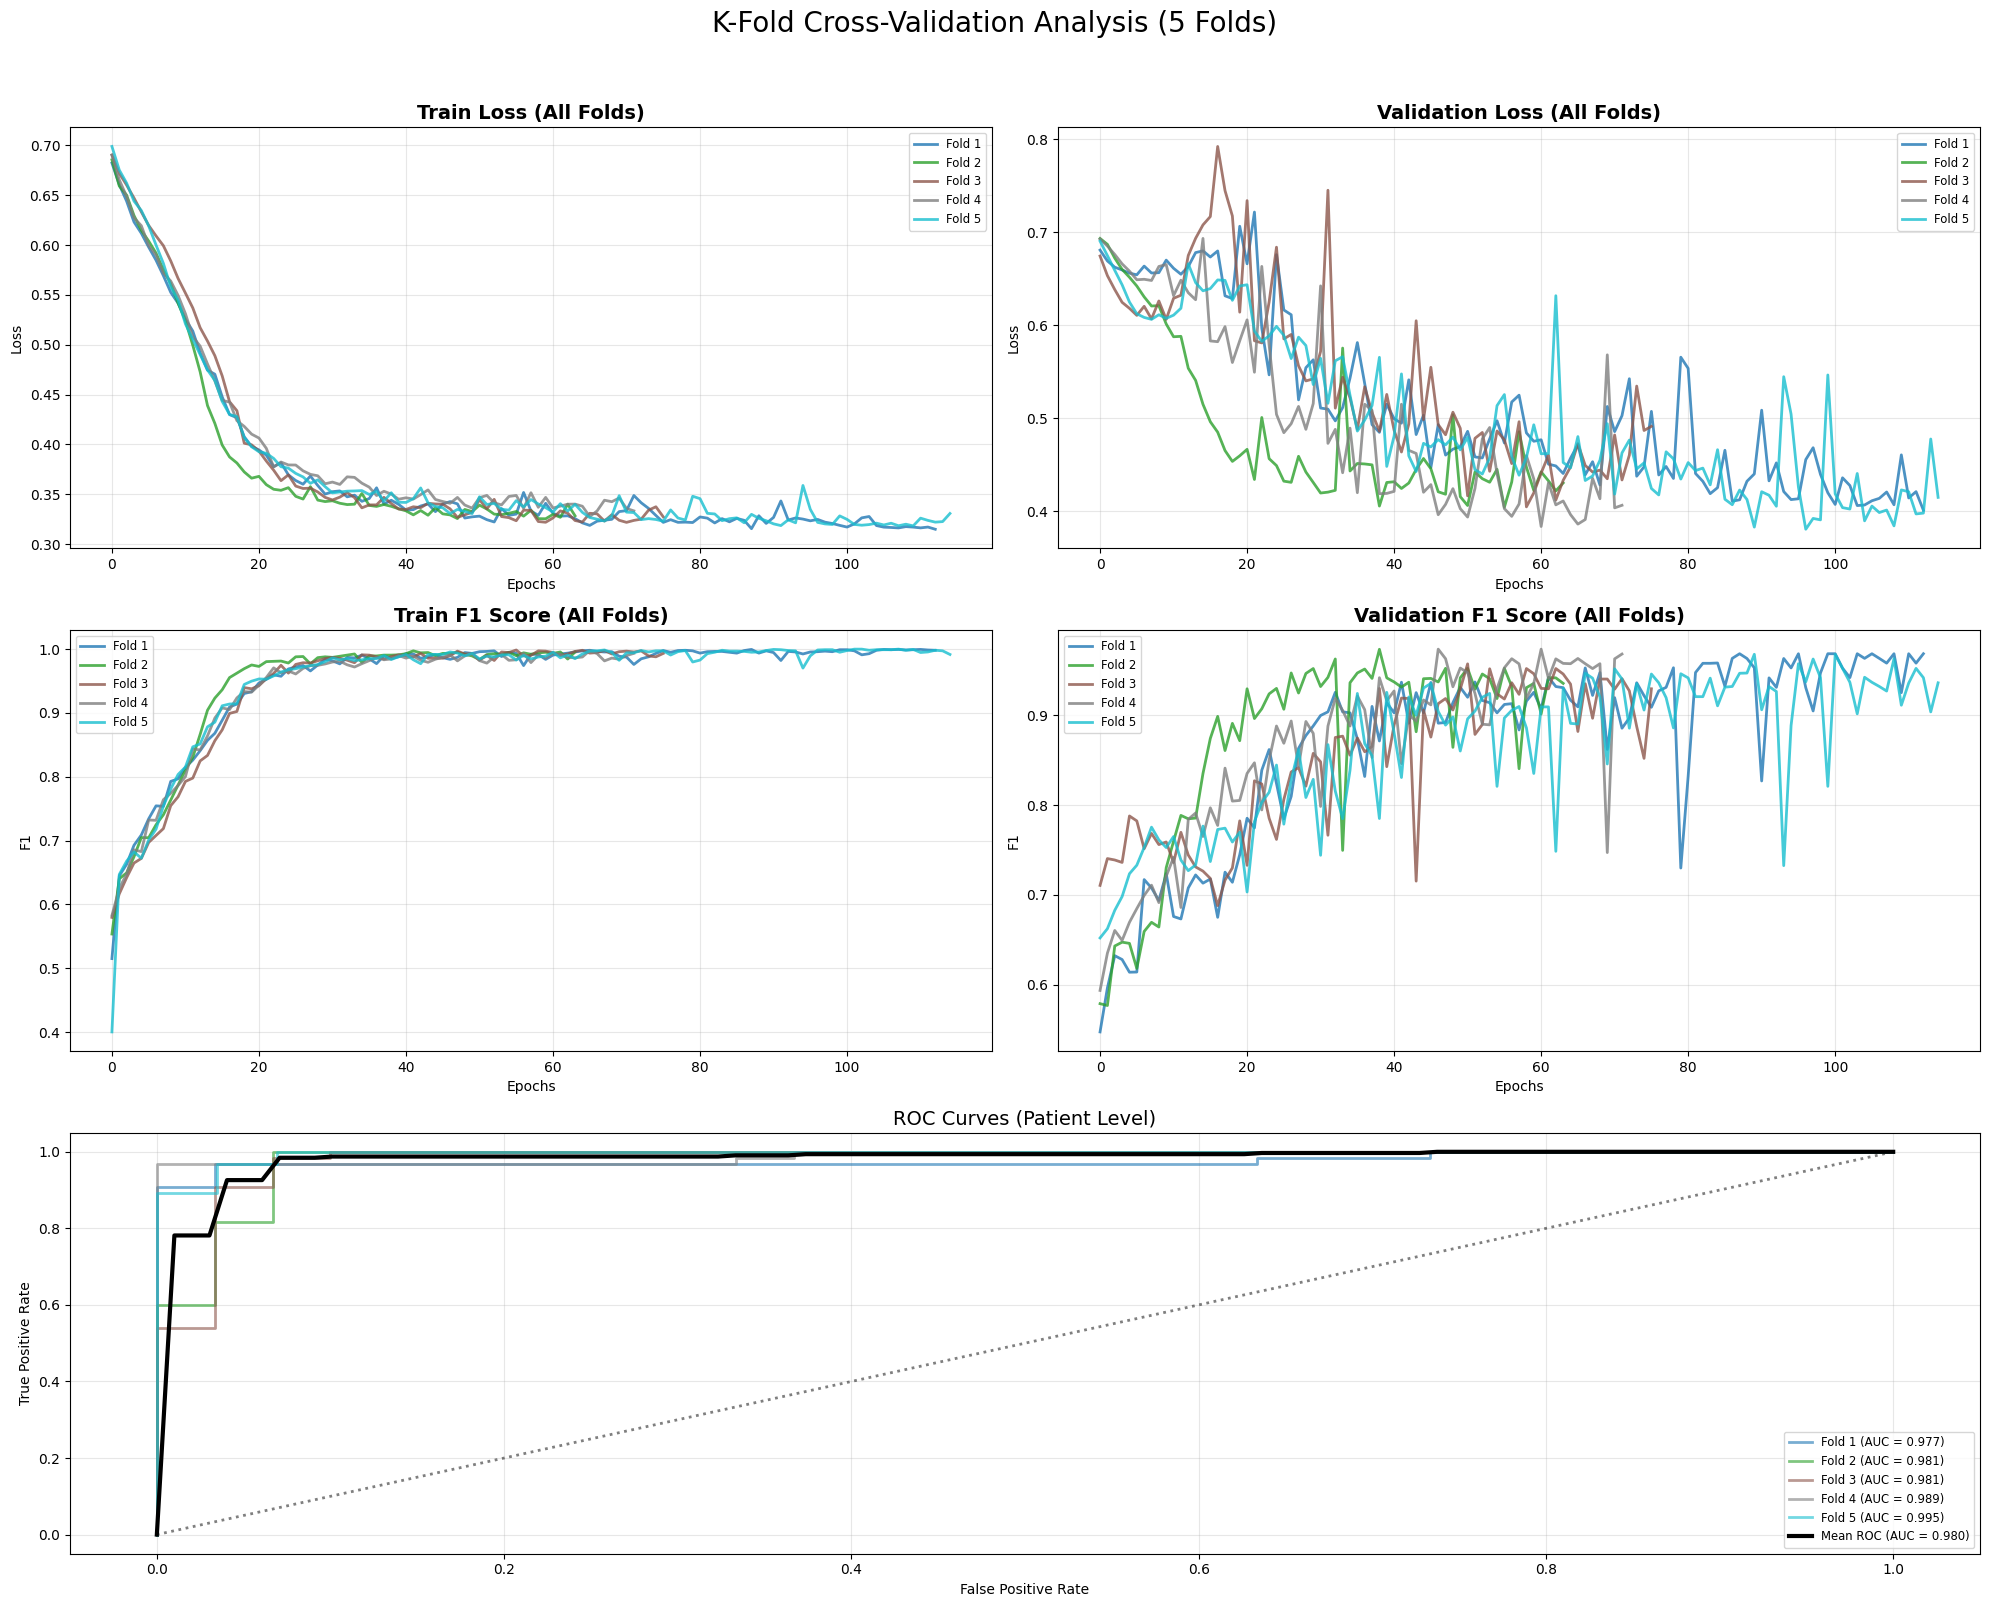

In [29]:
plot_kfold_results(all_histories, all_roc_data)

# Inference


In [ ]:
# BEST THRESHOLD for soft voting +  fold weight based on f1
oof_probs = np.array(oof_probs)
oof_targets = np.array(oof_targets)

best_thr = 0.5
best_f1 = 0.0

for thr in np.arange(0.1, 0.9, 0.01):
    preds_bin = (oof_probs > thr).astype(int)
    score = f1_score(oof_targets, preds_bin, average='weighted')
    
    if score > best_f1:
        best_f1 = score
        best_thr = thr

print(f"\nBest Threshold: {best_thr:.4f}")


BEST_THRESHOLD = best_thr 
FOLD_WEIGHTS = np.array(fold_results) 




🔥 SOGLIA OTTIMALE TROVATA: 0.5800
   F1 con soglia 0.50: 0.9661
   F1 con soglia 0.5800: 0.9683


Dataset ready: 106 segments --> 53 patients

Start Inference with 5 models...
   -> LOADED: /kaggle/working/fold_1_model.pt
   -> LOADED: /kaggle/working/fold_2_model.pt
   -> LOADED: /kaggle/working/fold_3_model.pt
   -> LOADED: /kaggle/working/fold_4_model.pt
   -> LOADED: /kaggle/working/fold_5_model.pt



FINAL RESULTS ON TEST SET
F1 Score (Weighted): 0.9255
Accuracy:            0.9245
Recall:              0.9245
ROC AUC:             0.9951

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.94      0.89        17
           1       0.97      0.92      0.94        36

    accuracy                           0.92        53
   macro avg       0.91      0.93      0.92        53
weighted avg       0.93      0.92      0.93        53



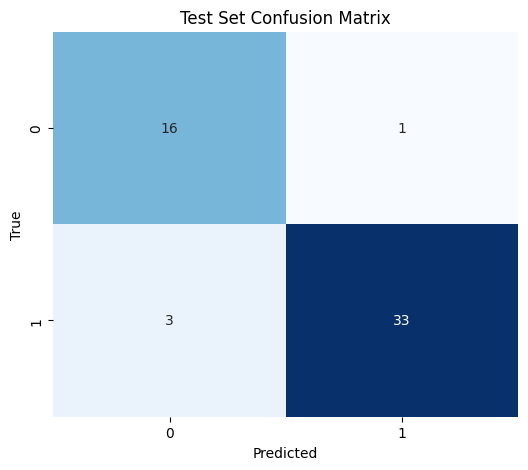

In [31]:
# ensemble averaging



final_scaler = MinMaxScaler()

final_scaler.fit(X_tab_train[COLS_TO_SCALE])
X_tab_test_scaled = process_tabular_data(X_tab_test, final_scaler, COLS_TO_SCALE)


# use stride_val
X_sig_test_seq, X_tab_test_seq, y_test_seq, ids_test_seq = build_sequences(
    X_sig_test_norm,      
    X_tab_test_scaled, 
    y_test, 
    WINDOW_SIZE, 
    STRIDE_VAL   # --> test STRIDE_TRAIN or 250/500
)

# Dataset e Loader
test_ds = ECGThreeBranchDataset(X_sig_test_seq, X_tab_test_seq, y_test_seq, is_train=False)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False) 

print(f"Dataset ready: {len(y_test_seq)} segments --> {len(np.unique(ids_test_seq))} patients")




# 2. PREDICTION LOOP (ENSEMBLE)

all_models_probs = np.zeros((len(y_test_seq), N_SPLITS))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\nStart Inference with {N_SPLITS} models...")

for fold_idx in range(N_SPLITS):
    model_path = f"{model_dir}/fold_{fold_idx+1}_model.pt"
    
    # empty model
    model, _ = get_model_optimizer(device, N_TAB_FEATURES, N_CLASSES, dropout=DROPOUT_RATE, base_channels = BASE_CHANNELS)
    
    # load saved weight
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"   -> LOADED: {model_path}")
    else:
        print(f"    ATTENTION: model {model_path} not found!")
        continue
    

    probs, _ = get_all_probs(model, test_loader, device)
    
    all_models_probs[:, fold_idx] = probs
    
    del model
    torch.cuda.empty_cache()



# 3. AGGREGATION (SOFT VOTING)

weights = FOLD_WEIGHTS / np.sum(FOLD_WEIGHTS)

# weighted mean between K models --> each segment
avg_probs_segment = np.average(all_models_probs, axis=1, weights=weights)

# patient aggregation
df_test_results = pd.DataFrame({
    'ECG_patient_id': ids_test_seq,
    'prob_1': avg_probs_segment,
    'target': y_test_seq
})

final_patient_preds = df_test_results.groupby('ECG_patient_id').agg({
    'prob_1': 'mean',
    'target': 'max' 
}).reset_index()


# FINAL METRICS
y_true_final = final_patient_preds['target'].values
y_prob_final = final_patient_preds['prob_1'].values
y_pred_final = (y_prob_final > BEST_THRESHOLD).astype(int)



print("\n\n\n" + "="*50)
print("FINAL RESULTS ON TEST SET")
print("="*50)

# save & print metrics
f1 = f1_score(y_true_final, y_pred_final, average='weighted')
acc = accuracy_score(y_true_final, y_pred_final)
roc_auc = roc_auc_score(y_true_final, y_prob_final)
recall = recall_score(y_true_final, y_pred_final, average='weighted')

print(f"F1 Score (Weighted): {f1:.4f}")
print(f"Accuracy:            {acc:.4f}")
print(f"Recall:              {recall:.4f}")
print(f"ROC AUC:             {roc_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true_final, y_pred_final))

# confusion matrix
cm = confusion_matrix(y_true_final, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()

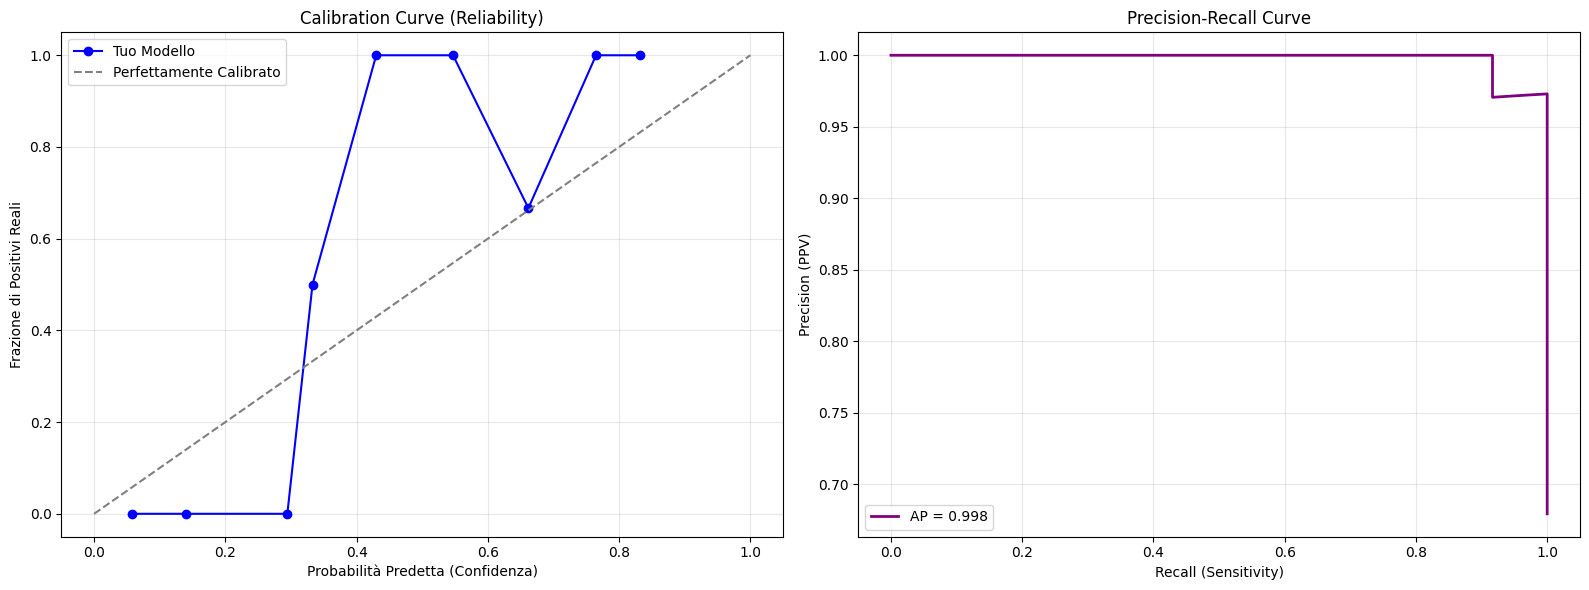

In [32]:
plot_advanced_metrics(y_true_final, y_prob_final)
#1. to see how the model is confident on prediction
#2. average precision

----------------------------------------------------------------------------------------------------------------------------------------------------------------